# Deep Knowledge Tracing using RNN (LSTM) model

Dataset: Assistments 2017

# Data Layer

Import Dataset from Drive

In [5]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

assistments = pd.read_csv('/content/drive/MyDrive/DeepKT/assistments_2017.csv')

Mounted at /content/drive


<ipython-input-5-fc93e142744a>:6: DtypeWarning: Columns (76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  assistments = pd.read_csv('/content/drive/MyDrive/DeepKT/assistments_2017.csv')


**Assistments 2017**

We will use mainly 2 columns from the dataframe: Skill and Correctness, the other two columns will be for aiding preprocessing.

In [ ]:
assistments[['studentId', 'skill', 'correct', 'action_num']].head(15000)

assistments['skill'].nunique()

102

# Preprocess

In [ ]:
print(assistments['studentId'].nunique())

1709


In [ ]:
import pandas as pd
import numpy as np

from dataclasses import dataclass
from typing import Tuple, List, Dict

@dataclass
class SequenceConfig:
  seq_length: int
  sliding_window_step: int = 1
  max_students: int = 100

class SequenceGenerator:
  def __init__(self, config: SequenceConfig, skill_to_id: Dict):
    self.config = config # Configuring the parameters for preprocessing
    self.skill_to_id = {} # Mapping skills to unique IDs

  def load_and_process(self, file) -> Tuple[pd.DataFrame, int]:
    # Load and preprocess data from Dataset
    data = file

    num_skills = data['skill'].nunique()

    data.sort_values(by=['studentId', 'action_num'])

    selected_students = data['studentId'].unique()[:self.config.max_students]
    data = data[data['studentId'].isin(selected_students)]

    self.skill_to_id = self.skill_map(data)

    return data, num_skills

  def skill_map(self, data: pd.DataFrame) -> Dict[str, int]:
    skill_to_id = {}

    for skill in data['skill'].unique():
      skill_to_id[skill] = len(skill_to_id)

    return skill_to_id

  def encode_interaction(self, skill: int, correctness: int) -> int:
    # Encode each possible interaction uniquely as a number
    return 2 * skill + correctness

  def generate_label(self, num_skills: int, skill: int, correctness: int) -> List[int]:
    # Create labels to calculate BCE loss
    label = np.zeros(num_skills)
    label[skill] = correctness
    return label

  def prepare_student_sequences(self, student_data: pd.DataFrame, num_skills: int) -> Tuple[List, List]:
    # Prepare sequences for each student
    sequences = []
    labels = []

    print('Checkpoint', student_data['studentId'])

    if len(student_data) < self.config.seq_length:
      return sequences, labels

    for i in range(0, len(student_data) - self.config.seq_length, self.config.sliding_window_step):
      if i + self.config.seq_length > len(student_data):
        break

      window = student_data.iloc[i: i + self.config.seq_length]

      next_interaction = student_data.iloc[i + self.config.seq_length]

      encoded_sequence = [self.encode_interaction(self.skill_to_id[row['skill']], row['correct']) for _, row in window.iterrows()]

      sequences.append(encoded_sequence)

      labels.append(window['correct'].tolist())

    return sequences, labels

  def prepare_sequences(self, df: pd.DataFrame, num_skills: int) -> Tuple[List, List]:
    all_sequences = []
    all_labels = []

    for student_id in df['studentId'].unique():
      student_data = df[df['studentId'] == student_id]

      student_seq, student_lab = self.prepare_student_sequences(student_data, num_skills)

      all_sequences.extend(student_seq)
      all_labels.extend(student_lab)

    return all_sequences, all_labels

gen = SequenceGenerator(SequenceConfig(10, 1, 1200), {})

df, num_skills = gen.load_and_process(assistments)

df.head(100)

seq, lab = gen.prepare_sequences(df, num_skills)


# **Save and Load Functions**

In [ ]:
import pickle
import json
import os

def save_preprocessed_data(sequences, labels, skill_to_id, config, save_dir='/content/drive/MyDrive/DeepKT/preprocessed_data'):
    """Save preprocessed data to Google Drive"""
    # Mount Google Drive if not already mounted
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    os.makedirs(save_dir, exist_ok=True)

    # Save sequences and labels
    np.save(os.path.join(save_dir, 'sequences_10_s10.npy'), np.array(sequences))
    np.save(os.path.join(save_dir, 'labels_10_s10.npy'), np.array(labels))

    # Save skill mapping and configuration
    metadata = {
        'skill_to_id': skill_to_id,
        'config': {
            'seq_length': config.seq_length,
            'sliding_window_step': config.sliding_window_step,
            'num_students': config.max_students
        },
        'dataset_stats': {
            'num_sequences': len(sequences),
            'sequence_length': len(sequences[0]) if sequences else 0,
            'num_skills': len(skill_to_id)
        }
    }

    with open(os.path.join(save_dir, 'metadata_10_s10.json'), 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Data saved successfully to {save_dir}")
    print("Files saved:")
    print(f"- sequences_10_s10.npy: {os.path.getsize(os.path.join(save_dir, 'sequences_10_s10.npy'))/1024/1024:.2f} MB")
    print(f"- labels_10_s10.npy: {os.path.getsize(os.path.join(save_dir, 'labels_10_s10.npy'))/1024/1024:.2f} MB")
    print(f"- metadata_10_s10.json: {os.path.getsize(os.path.join(save_dir, 'metadata_10_s10.json'))/1024:.2f} KB")

# # Save Preprocessed Data:
save_preprocessed_data(seq, lab, gen.skill_to_id, gen.config)

Data saved successfully to /content/drive/MyDrive/DeepKT/preprocessed_data
Files saved:
- sequences_10_s10.npy: 5.65 MB
- labels_10_s10.npy: 5.65 MB
- metadata_10_s10.json: 3.19 KB


# **In case already preprocessed, load initial packages and start here**

In [11]:
import pickle
import json
import os
from google.colab import drive
import numpy as np

def load_preprocessed_data(load_dir='/content/drive/MyDrive/DeepKT/preprocessed_data'):
    """Load preprocessed data from Google Drive"""
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # Load sequences and labels
    sequences = np.load(os.path.join(load_dir, 'sequences_30.npy'))
    labels = np.load(os.path.join(load_dir, 'labels_30.npy'))

    # Load metadata
    with open(os.path.join(load_dir, 'metadata_30.json'), 'r') as f:
        metadata = json.load(f)

    print("Data loaded successfully")
    print(f"Loaded {metadata['dataset_stats']['num_sequences']} sequences")
    print(f"Sequence length: {metadata['dataset_stats']['sequence_length']}")
    print(f"Number of skills: {metadata['dataset_stats']['num_skills']}")

    return sequences, labels, metadata

# Load in preprocessed data
sequences, labels, metadata = load_preprocessed_data()

print(sequences[:50])
print(labels[:50])

Data loaded successfully
Loaded 94810 sequences
Sequence length: 30
Number of skills: 90
[[ 0  1  2 ... 11 11 14]
 [ 1  2  2 ... 11 14 14]
 [ 2  2  3 ... 14 14 15]
 ...
 [10 23 13 ... 35 35 37]
 [23 13 11 ... 35 37 37]
 [13 11 10 ... 37 37 37]]
[[0 1 0 ... 1 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 1]
 ...
 [0 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]]


# Data Transformation

In [12]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_data(sequences, labels, batch_size = 64, train_ratio = 0.9, val_ratio = 0.01):
  sequences = sequences.astype(np.int32)
  labels = labels.astype(np.float32)

  train_sequences, temp_sequences, train_labels, temp_labels = train_test_split(sequences, labels, train_size=train_ratio, random_state=42)

  val_ratio_adjusted = val_ratio / (1 - train_ratio)

  val_sequences, test_sequences, val_labels, test_labels = train_test_split(temp_sequences, temp_labels, train_size=val_ratio_adjusted, random_state=42)

  def create_dataset(sequences, labels, batch_size, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((sequences, labels))

    if training:
      dataset = dataset.shuffle(len(sequences)) # Shuffle tensors

    dataset = dataset.batch(batch_size)

    if training:
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # Prefetch for optimum training

    return dataset

  train_dataset = create_dataset(train_sequences, train_labels, batch_size)
  val_dataset = create_dataset(val_sequences, val_labels, batch_size)
  test_dataset = create_dataset(test_sequences, test_labels, batch_size)

  return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = prepare_data(sequences, labels)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

def inspect_dataset(dataset, name="Dataset"):
    """Helper function to inspect the prepared datasets"""
    for sequences, labels in dataset.take(1):
        print(f"\n{name} inspection:")
        print(f"Sequences shape: {sequences.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Sequences dtype: {sequences.dtype}")
        print(f"Labels dtype: {labels.dtype}")
        print("\nSample sequence (first in batch):")
        print("Encoded interactions:", sequences[0])
        print("Correctness labels:", labels[0])

inspect_dataset(train_dataset, "Training")
inspect_dataset(val_dataset, "Validation")
inspect_dataset(test_dataset, "Test")

1334
15
134

Training inspection:
Sequences shape: (64, 30)
Labels shape: (64, 30)
Sequences dtype: <dtype: 'int32'>
Labels dtype: <dtype: 'float32'>

Sample sequence (first in batch):
Encoded interactions: tf.Tensor(
[15 10 11 12 12 12 12 12 13 12 12 12 13 24 24 25 24 24 25 24 25 24 24 24
 24 24 25 24 24 24], shape=(30,), dtype=int32)
Correctness labels: tf.Tensor(
[1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0.], shape=(30,), dtype=float32)

Validation inspection:
Sequences shape: (64, 30)
Labels shape: (64, 30)
Sequences dtype: <dtype: 'int32'>
Labels dtype: <dtype: 'float32'>

Sample sequence (first in batch):
Encoded interactions: tf.Tensor(
[ 52  52  52 104  99 104 105  67 104 105  91  10  11  12  13  12  50  52
  52  53  52  52  52  52  52  52  52  50  53  53], shape=(30,), dtype=int32)
Correctness labels: tf.Tensor(
[0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1.], shape=(30,), dtype=float32

# LSTM Implementation

In [8]:
import tensorflow as tf
import time
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

class LSTMModel(tf.keras.Model):
    def __init__(self, num_items, seq_len, embed_dim, lstm_units, mlp_units, dropout_rate=0.1):
        """
        Args:
          num_items: Size of the item vocabulary.
          seq_len: The sequence length.
          embed_dim: Embedding dimension for items.
          lstm_units: Number of units in the LSTM layer.
          mlp_units: A list with the number of units for each MLP Dense layer.
          dropout_rate: Dropout rate to use after Dense layers.
        """
        super(LSTMModel, self).__init__()
        self.seq_len = seq_len

        # Embedding for items and positional encoding (optional but useful)
        self.embedding = tf.keras.layers.Embedding(num_items, embed_dim)
        self.pos_encoding = tf.keras.layers.Embedding(seq_len, embed_dim)

        # LSTM layer (set return_sequences=True to output a sequence)
        self.lstm_layer = tf.keras.layers.LSTM(lstm_units, return_sequences=True)

        # MLP layers
        self.mlp_layers = []
        for mlp_dim in mlp_units:
            self.mlp_layers.append(tf.keras.layers.Dense(mlp_dim, activation='relu'))
            self.mlp_layers.append(tf.keras.layers.Dropout(dropout_rate))

        # Final prediction layer (sigmoid activation for binary prediction)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        """
        Args:
          inputs: Tensor of shape (batch_size, seq_len)
          training: Boolean flag for dropout behavior.

        Returns:
          predictions: Tensor of shape (batch_size, seq_len) with probabilities.
        """
        batch_size = tf.shape(inputs)[0]
        # Create positional indices and retrieve positional encodings
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        positions = tf.expand_dims(positions, axis=0)             # Shape: (1, seq_len)
        positions = tf.tile(positions, [batch_size, 1])             # Shape: (batch_size, seq_len)

        # Get item embeddings and add positional encoding
        x = self.embedding(inputs)              # (batch_size, seq_len, embed_dim)
        pos_enc = self.pos_encoding(positions)  # (batch_size, seq_len, embed_dim)
        x = x + pos_enc

        # Process with LSTM
        x = self.lstm_layer(x)  # (batch_size, seq_len, lstm_units)

        # Pass through the MLP layers
        for layer in self.mlp_layers:
            if isinstance(layer, tf.keras.layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)

        # Final prediction layer produces shape (batch_size, seq_len, 1)
        x = self.final_layer(x)
        # Remove last dimension so the output shape becomes (batch_size, seq_len)
        return tf.squeeze(x, -1)

# Training

In [ ]:
# ===============================================
# Training, Evaluation, and Testing Code
# ===============================================

# ----- Custom Training Step -----
@tf.function
def train_step(model, optimizer, batch_sequences, batch_labels):
    """
    Performs one training step for a batch.

    Args:
      model: The LSTM model.
      optimizer: An instance of tf.keras.optimizers.
      batch_sequences: Tensor of shape (batch_size, seq_len) representing input tokens.
      batch_labels: Tensor of shape (batch_size, seq_len) with ground truth labels.

    Returns:
      loss: The average loss for the batch.
    """
    with tf.GradientTape() as tape:
        # Forward pass: get predictions
        predictions = model(batch_sequences, training=True)
        # In knowledge tracing, we predict the outcome of the *next* step:
        # Compare predictions at time t with labels at time t+1
        pred = predictions[:, :-1]
        target = tf.cast(batch_labels[:, 1:], tf.float32)
        loss = tf.keras.losses.binary_crossentropy(target, pred)
        loss = tf.reduce_mean(loss)

    # Backpropagation and optimizer step
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# ----- Evaluation Function -----
def evaluate_model(model, dataset):
    """
    Evaluates the model over an entire dataset.

    Args:
      model: The LSTM model.
      dataset: A tf.data.Dataset yielding (batch_sequences, batch_labels) where each tensor is of shape (batch_size, seq_len).

    Returns:
      auc: ROC-AUC computed over all predictions.
      accuracy: Binary accuracy computed over all predictions.
    """
    all_preds = []
    all_labels = []

    for batch_sequences, batch_labels in dataset:
        predictions = model(batch_sequences, training=False)
        # Shift predictions and labels so that prediction at time t is compared with label at time t+1
        pred = predictions[:, :-1]
        target = batch_labels[:, 1:]

        all_preds.append(pred)
        all_labels.append(target)

    # Concatenate outputs across batches
    all_preds = tf.concat(all_preds, axis=0)
    all_labels = tf.concat(all_labels, axis=0)

    # Flatten the tensors to compute scalar metrics
    all_preds_np = all_preds.numpy().flatten()
    all_labels_np = all_labels.numpy().flatten()

    try:
        auc = roc_auc_score(all_labels_np, all_preds_np)
    except Exception as e:
        print("Error computing AUC:", e)
        auc = 0.0

    y_pred_bin = (all_preds_np > 0.5).astype(int)
    accuracy = accuracy_score(all_labels_np, y_pred_bin)

    return auc, accuracy

# ----- Complete Training Loop -----
def train_model(model, train_dataset, val_dataset, test_dataset, epochs=50, patience=10, learning_rate=0.001):
    """
    Trains the model using a custom training loop, printing metrics during training and evaluating on
    the training, validation, and test datasets after each epoch.

    Args:
      model: The LSTM model.
      train_dataset: tf.data.Dataset for training.
      val_dataset: tf.data.Dataset for validation.
      test_dataset: tf.data.Dataset for testing.
      epochs: Maximum number of epochs to train.
      patience: Number of epochs to wait for improvement before early stopping.
      learning_rate: Learning rate for the optimizer.

    Returns:
      model: The trained model (with the best weights restored).
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    best_test_auc = 0.0
    patience_counter = 0
    best_weights = None

    for epoch in range(epochs):
        start_time = time.time()
        train_loss_metric = tf.keras.metrics.Mean()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training loop over batches
        for batch_idx, (batch_sequences, batch_labels) in enumerate(train_dataset):
            loss = train_step(model, optimizer, batch_sequences, batch_labels)
            train_loss_metric.update_state(loss)

            if (batch_idx + 1) % 50 == 0:
                print(f"  Batch {batch_idx+1} - Loss: {loss:.4f}")

        epoch_loss = train_loss_metric.result().numpy()
        print(f"Epoch {epoch+1} - Average Training Loss: {epoch_loss:.4f}")

        # Evaluate on training, validation, and test datasets
        # train_auc, train_accuracy = evaluate_model(model, train_dataset)
        # print(f"  Training Metrics - AUC: {train_auc:.4f} | Accuracy: {train_accuracy:.4f}")

        # val_auc, val_accuracy = evaluate_model(model, val_dataset)
        # print(f"  Validation Metrics - AUC: {val_auc:.4f} | Accuracy: {val_accuracy:.4f}")

        test_auc, test_accuracy = evaluate_model(model, test_dataset)
        print(f"  Test Metrics - AUC: {test_auc:.4f} | Accuracy: {test_accuracy:.4f}")

        # Early stopping check (based on validation AUC)
        if test_auc > best_test_auc:
            best_test_auc = test_auc
            best_weights = model.get_weights()
            patience_counter = 0
            print("  New best model found!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  Early stopping triggered!")
                break

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1} took {epoch_time:.2f}s")

    # Restore best model weights if available
    if best_weights is not None:
        model.set_weights(best_weights)
        print(f"\nTraining completed. Best Validation AUC: {best_test_auc:.4f}")

    final_test_auc, final_test_accuracy = evaluate_model(model, test_dataset)
    print(f"\nFinal Test Metrics - AUC: {final_test_auc:.4f} | Accuracy: {final_test_accuracy:.4f}")
    return model

# Instantiate the LSTM-based model:
lstm_model = LSTMModel(
    num_items=2 * len(metadata['skill_to_id']),
    seq_len=metadata['config']['seq_length'],
    embed_dim=64,
    lstm_units=128,
    mlp_units=[128, 64],
    dropout_rate=0.1
)

# Train the model (this will print metrics during training and after each epoch):
trained_lstm_model = train_model(
    model=lstm_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    epochs=50,
    patience=10,
    learning_rate=0.001
)


Epoch 1/50
  Batch 50 - Loss: 0.5967
  Batch 100 - Loss: 0.6322
  Batch 150 - Loss: 0.6288
  Batch 200 - Loss: 0.5724
  Batch 250 - Loss: 0.6176
  Batch 300 - Loss: 0.6124
  Batch 350 - Loss: 0.5922
  Batch 400 - Loss: 0.6007
  Batch 450 - Loss: 0.5983
  Batch 500 - Loss: 0.6007
  Batch 550 - Loss: 0.5770
  Batch 600 - Loss: 0.6111
  Batch 650 - Loss: 0.5964
  Batch 700 - Loss: 0.5855
  Batch 750 - Loss: 0.5824
  Batch 800 - Loss: 0.5933
  Batch 850 - Loss: 0.6074
  Batch 900 - Loss: 0.5844
  Batch 950 - Loss: 0.5742
  Batch 1000 - Loss: 0.6002
  Batch 1050 - Loss: 0.5976
  Batch 1100 - Loss: 0.5630
Epoch 1 - Average Training Loss: 0.5978
  Test Metrics - AUC: 0.6927 | Accuracy: 0.6943
  New best model found!
Epoch 1 took 11.65s

Epoch 2/50
  Batch 50 - Loss: 0.5653
  Batch 100 - Loss: 0.6034
  Batch 150 - Loss: 0.5873
  Batch 200 - Loss: 0.5416
  Batch 250 - Loss: 0.5980
  Batch 300 - Loss: 0.5888
  Batch 350 - Loss: 0.5671
  Batch 400 - Loss: 0.5829
  Batch 450 - Loss: 0.5940
  Batc

# Save and Load Model

In [ ]:
import os
import tensorflow as tf

# ====================================================
# Save the LSTM model weights
# ====================================================
save_dir = "/content/drive/MyDrive/DeepKT/saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

lstm_model_save_path = os.path.join(save_dir, "seq10_trained_lstm_model.weights.h5")
trained_lstm_model.save_weights(lstm_model_save_path)
print(f"Model weights saved to {lstm_model_save_path}")


NameError: name 'trained_lstm_model' is not defined

In [9]:
import os
import tensorflow as tf
import json

load_dir = '/content/drive/MyDrive/DeepKT/preprocessed_data'
metadata = None

with open(os.path.join(load_dir, 'metadata_30.json'), 'r') as f:
        metadata = json.load(f)

# ====================================================
# Save the LSTM model weights
# ====================================================
save_dir = "/content/drive/MyDrive/DeepKT/saved_models"
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

lstm_model_save_path = os.path.join(save_dir, "seq30_trained_lstm_model.weights.h5")
# trained_lstm_model.save_weights(lstm_model_save_path)
# print(f"Model weights saved to {lstm_model_save_path}")

# ====================================================
# Load the LSTM model for evaluation & visualization
# ====================================================
# Recreate the LSTM model architecture with the same configuration.
loaded_lstm_model = LSTMModel(
    num_items=2 * len(metadata['skill_to_id']),
    seq_len=metadata['config']['seq_length'],
    embed_dim=64,
    lstm_units=128,
    mlp_units=[128, 64],
    dropout_rate=0.1
)

# Build the model by passing a dummy input.
dummy_input = tf.zeros((1, metadata['config']['seq_length']))
_ = loaded_lstm_model(dummy_input, training=False)

# Load the saved weights.
loaded_lstm_model.load_weights(lstm_model_save_path)
print(f"Model loaded from {lstm_model_save_path}")

Model loaded from /content/drive/MyDrive/DeepKT/saved_models/seq30_trained_lstm_model.weights.h5


# Visualization

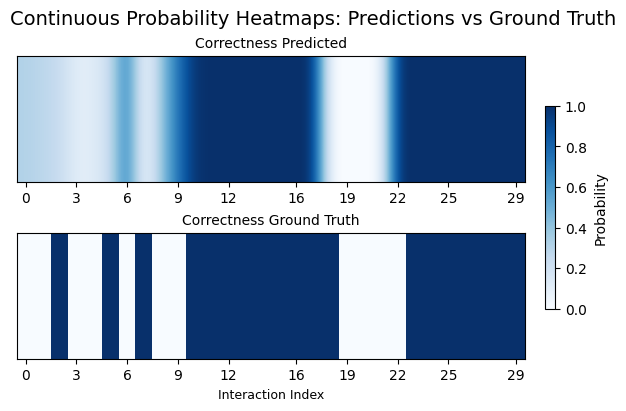

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # assuming tensorflow is used as in your original code

def visualize_continuous_gradient_heatmaps_separated(model, dataset):
    """
    Visualize two samples' performance over time as continuous gradient heatmaps,
    with predictions and ground truth in separate subplots.

    For each of the two selected samples (one balanced and one high-correct), the function:
      1. Computes model predictions (without binning).
      2. Plots the predicted probabilities and ground truth in separate subplots.

    The figure is arranged as a 2x2 grid:
      - Top row: Predicted probabilities (continuous gradient using bicubic interpolation).
      - Bottom row: Ground truth (displayed using nearest interpolation).
      - Left column: Balanced sample (ground truth average closest to 0.5).
      - Right column: High-correct sample (highest average correctness).

    The figure height is reduced (e.g., figsize=(12, 4)), and a shared colorbar is provided.
    """
    # Retrieve one batch from the dataset.
    for batch_sequences, batch_labels in dataset.take(1):
        break

    # Convert tensors to NumPy arrays.
    batch_sequences_np = batch_sequences.numpy()
    batch_labels_np = batch_labels.numpy()

    # Compute average correctness for each sample.
    avg_correct = np.mean(batch_labels_np, axis=1)

    # Select one balanced sample (closest to 0.5) and one high-correct sample.
    balanced_index = np.argmin(np.abs(avg_correct - 0.5))
    high_correct_index = np.argmax(avg_correct)

    # Obtain predictions and ground truth for the selected samples.
    pred_balanced = model(batch_sequences_np[balanced_index:balanced_index+1], training=False).numpy()[0]
    pred_high = model(batch_sequences_np[high_correct_index:high_correct_index+1], training=False).numpy()[0]

    gt_balanced = batch_labels_np[balanced_index]
    gt_high = batch_labels_np[high_correct_index]

    seq_len = len(pred_balanced)

    # Create a 2x2 grid of subplots with reduced overall height.
    fig, axes = plt.subplots(2, 1, figsize=(6, 4), constrained_layout=True)
    vmin, vmax = 0, 1  # Common color scale.

    # # Top-left: Balanced sample predicted probabilities.
    # im1 = axes[0, 0].imshow(
    #     pred_balanced[np.newaxis, :],
    #     aspect='auto', cmap='Blues',
    #     origin='upper', interpolation='bicubic',
    #     vmin=vmin, vmax=vmax
    # )
    # axes[0, 0].set_title(f"Balanced Predicted\n(Index: {balanced_index}, Avg: {avg_correct[balanced_index]:.2f})", fontsize=10)
    # axes[0, 0].set_yticks([])
    # axes[0, 0].set_xticks(np.linspace(0, seq_len - 1, num=10, dtype=int))
    # axes[0, 0].set_xlabel("Time Step", fontsize=9)

    # Top-right: High-correct sample predicted probabilities.
    im2 = axes[0].imshow(
        pred_high[np.newaxis, :],
        aspect='auto', cmap='Blues',
        origin='upper', interpolation='bicubic',
        vmin=vmin, vmax=vmax
    )
    axes[0].set_title(f"Correctness Predicted", fontsize=10)
    axes[0].set_yticks([])
    axes[0].set_xticks(np.linspace(0, seq_len - 1, num=10, dtype=int))
    # # Bottom-left: Balanced sample ground truth.
    # im3 = axes[1, 0].imshow(
    #     gt_balanced[np.newaxis, :],
    #     aspect='auto', cmap='Blues',
    #     origin='upper', interpolation='nearest',
    #     vmin=vmin, vmax=vmax
    # )
    # axes[1, 0].set_title("Balanced Ground Truth", fontsize=10)
    # axes[1, 0].set_yticks([])
    # axes[1, 0].set_xticks(np.linspace(0, seq_len - 1, num=10, dtype=int))
    # axes[1, 0].set_xlabel("Time Step", fontsize=9)

    # Bottom-right: High-correct sample ground truth.
    im4 = axes[1].imshow(
        gt_high[np.newaxis, :],
        aspect='auto', cmap='Blues',
        origin='upper', interpolation='nearest',
        vmin=vmin, vmax=vmax
    )
    axes[1].set_title("Correctness Ground Truth", fontsize=10)
    axes[1].set_yticks([])
    axes[1].set_xticks(np.linspace(0, seq_len - 1, num=10, dtype=int))
    axes[1].set_xlabel("Interaction Indices", fontsize=9)

    # Add a shared colorbar for the predicted heatmaps (top row) or for the entire figure.
    cbar = fig.colorbar(im2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, shrink=0.8)
    cbar.set_label('Probability', labelpad=5)

    fig.suptitle("Continuous Probability Heatmaps: Predictions vs Ground Truth", fontsize=14)
    plt.show()

visualize_continuous_gradient_heatmaps_separated(loaded_lstm_model, test_dataset)

# ROC Curve

Model loaded from /content/drive/MyDrive/DeepKT/saved_models/seq10_trained_lstm_model.weights.h5
Model loaded from /content/drive/MyDrive/DeepKT/saved_models/seq20_trained_lstm_model.weights.h5
Model loaded from /content/drive/MyDrive/DeepKT/saved_models/seq30_trained_lstm_model.weights.h5
Data loaded successfully for prefix 10
Loaded 81387 sequences
Sequence length: 10
Number of skills: 89
Data loaded successfully for prefix 20
Loaded 80387 sequences
Sequence length: 20
Number of skills: 89
Data loaded successfully for prefix 30
Loaded 94810 sequences
Sequence length: 30
Number of skills: 90
Test dataset sizes:
Seq10: 115 batches
Seq20: 114 batches
Seq30: 134 batches


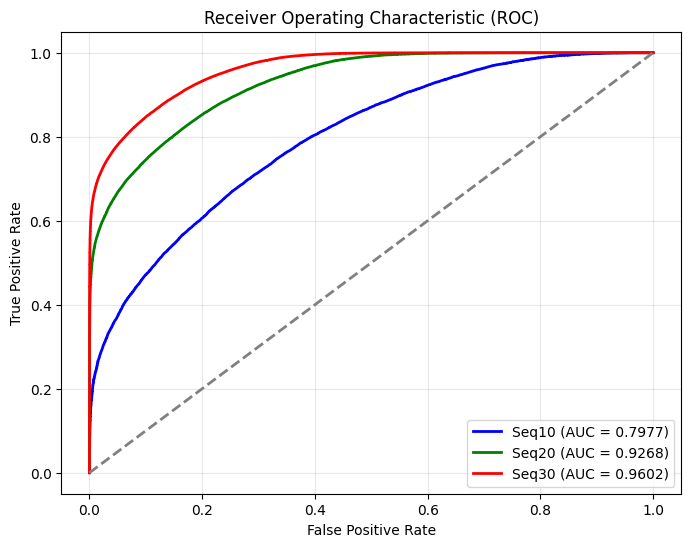

In [ ]:
load_dir = '/content/drive/MyDrive/DeepKT/preprocessed_data'

metadata_10 = None
metadata_20 = None
metadata_30 = None

with open(os.path.join(load_dir, 'metadata_10.json'), 'r') as f:
        metadata_10 = json.load(f)

with open(os.path.join(load_dir, 'metadata_20.json'), 'r') as f:
        metadata_20 = json.load(f)

with open(os.path.join(load_dir, 'metadata_30.json'), 'r') as f:
        metadata_30 = json.load(f)

lstm_model_save_path = os.path.join(save_dir, "seq10_trained_lstm_model.weights.h5")

loaded_lstm_model_10 = LSTMModel(
    num_items=2 * len(metadata_10['skill_to_id']),
    seq_len=metadata_10['config']['seq_length'],
    embed_dim=64,
    lstm_units=128,
    mlp_units=[128, 64],
    dropout_rate=0.1
)

# Build the model by passing a dummy input.
dummy_input = tf.zeros((1, metadata_10['config']['seq_length']))
_ = loaded_lstm_model_10(dummy_input, training=False)

# Load the saved weights.
loaded_lstm_model_10.load_weights(lstm_model_save_path)
print(f"Model loaded from {lstm_model_save_path}")

lstm_model_save_path = os.path.join(save_dir, "seq20_trained_lstm_model.weights.h5")

loaded_lstm_model_20 = LSTMModel(
    num_items=2 * len(metadata_20['skill_to_id']),
    seq_len=metadata_20['config']['seq_length'],
    embed_dim=64,
    lstm_units=128,
    mlp_units=[128, 64],
    dropout_rate=0.1
)

# Build the model by passing a dummy input.
dummy_input = tf.zeros((1, metadata_20['config']['seq_length']))
_ = loaded_lstm_model_20(dummy_input, training=False)

# Load the saved wights.
loaded_lstm_model_20.load_weights(lstm_model_save_path)
print(f"Model loaded from {lstm_model_save_path}")

lstm_model_save_path = os.path.join(save_dir, "seq30_trained_lstm_model.weights.h5")

loaded_lstm_model_30 = LSTMModel(
    num_items=2 * len(metadata_30['skill_to_id']),
    seq_len=metadata_30['config']['seq_length'],
    embed_dim=64,
    lstm_units=128,
    mlp_units=[128, 64],
    dropout_rate=0.1
)

# Build the model by passing a dummy input.
dummy_input = tf.zeros((1, metadata_30['config']['seq_length']))
_ = loaded_lstm_model_30(dummy_input, training=False)

# Load the saved weights.
loaded_lstm_model_30.load_weights(lstm_model_save_path)
print(f"Model loaded from {lstm_model_save_path}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

def load_preprocessed_data(prefix, load_dir='/content/drive/MyDrive/DeepKT/preprocessed_data'):
    """
    Load preprocessed data given a prefix (e.g., '10', '20', or '30').

    It loads sequences, labels, and metadata from files such as:
      sequences_{prefix}.npy, labels_{prefix}.npy, metadata_{prefix}.json.
    """
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    sequences_path = os.path.join(load_dir, f'sequences_{prefix}.npy')
    labels_path = os.path.join(load_dir, f'labels_{prefix}.npy')
    metadata_path = os.path.join(load_dir, f'metadata_{prefix}.json')

    sequences = np.load(sequences_path)
    labels = np.load(labels_path)

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    print(f"Data loaded successfully for prefix {prefix}")
    print(f"Loaded {metadata['dataset_stats']['num_sequences']} sequences")
    print(f"Sequence length: {metadata['dataset_stats']['sequence_length']}")
    print(f"Number of skills: {metadata['dataset_stats']['num_skills']}")

    return sequences, labels, metadata

def prepare_data(sequences, labels, batch_size=64, train_ratio=0.9, val_ratio=0.01):
    """
    Prepare train, validation, and test datasets from the given sequences and labels.
    Only the test dataset is needed for evaluation.
    """
    sequences = sequences.astype(np.int32)
    labels = labels.astype(np.float32)

    # Split data into training and temporary sets.
    train_sequences, temp_sequences, train_labels, temp_labels = train_test_split(
        sequences, labels, train_size=train_ratio, random_state=42
    )

    # Adjust validation ratio with respect to the temporary set.
    val_ratio_adjusted = val_ratio / (1 - train_ratio)
    val_sequences, test_sequences, val_labels, test_labels = train_test_split(
        temp_sequences, temp_labels, train_size=val_ratio_adjusted, random_state=42
    )

    def create_dataset(sequences, labels, batch_size, training=False):
        dataset = tf.data.Dataset.from_tensor_slices((sequences, labels))
        if training:
            dataset = dataset.shuffle(len(sequences))
        dataset = dataset.batch(batch_size)
        if training:
            dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    train_dataset = create_dataset(train_sequences, train_labels, batch_size)
    val_dataset = create_dataset(val_sequences, val_labels, batch_size)
    test_dataset = create_dataset(test_sequences, test_labels, batch_size)

    return train_dataset, val_dataset, test_dataset

# Load data and prepare datasets for each model version.
# For Seq10:
sequences_10, labels_10, metadata_10 = load_preprocessed_data(prefix='10')
_, _, test_dataset_10 = prepare_data(sequences_10, labels_10)

# For Seq20:
sequences_20, labels_20, metadata_20 = load_preprocessed_data(prefix='20')
_, _, test_dataset_20 = prepare_data(sequences_20, labels_20)

# For Seq30:
sequences_30, labels_30, metadata_30 = load_preprocessed_data(prefix='30')
_, _, test_dataset_30 = prepare_data(sequences_30, labels_30)

print("Test dataset sizes:")
print(f"Seq10: {len(test_dataset_10)} batches")
print(f"Seq20: {len(test_dataset_20)} batches")
print(f"Seq30: {len(test_dataset_30)} batches")

def compute_roc_curve(model, dataset):
    """
    Compute false positive rates, true positive rates, and AUC for a given model on a dataset.
    """
    all_preds = []
    all_labels = []
    for batch_sequences, batch_labels in dataset:
        predictions = model(batch_sequences, training=False)
        # Align predictions with labels by removing the final timestep.
        pred = predictions[:, :-1]
        target = batch_labels[:, 1:]
        all_preds.append(pred)
        all_labels.append(target)

    # Concatenate predictions and labels from all batches.
    all_preds = tf.concat(all_preds, axis=0)
    all_labels = tf.concat(all_labels, axis=0)
    y_scores = all_preds.numpy().flatten()
    y_true = all_labels.numpy().flatten()

    # Compute ROC curve and AUC.
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def plot_multi_roc_curves(models, model_names, datasets):
    """
    Compute and plot ROC curves for multiple models on the same graph,
    where each model is evaluated on its corresponding dataset.

    Args:
      models: List of trained models.
      model_names: List of names corresponding to each model.
      datasets: List of datasets corresponding to each model.
    """
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red']

    for model, name, dataset, color in zip(models, model_names, datasets, colors):
        fpr, tpr, roc_auc = compute_roc_curve(model, dataset)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f"{name} (AUC = {roc_auc:.4f})")

    # Plot diagonal line (random classifier).
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Assuming you have loaded your three models and their corresponding test datasets:
models = [loaded_lstm_model_10, loaded_lstm_model_20, loaded_lstm_model_30]
model_names = ["Seq10", "Seq20", "Seq30"]
datasets = [test_dataset_10, test_dataset_20, test_dataset_30]

# Plot the ROC curves for all three models on the same graph.
plot_multi_roc_curves(models, model_names, datasets)